In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0-dev20201111


In [2]:
cd /Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks

/Users/aidasaglinskas/Desktop/BC-MRI-AE/Colab Notebooks


In [3]:
%matplotlib inline
from datetime import datetime;now = datetime.now;t00 = now()
import os
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.mixture import BayesianGaussianMixture

#from contrastive_vae.celeb_utils import get_celeb_vae
#from contrastive_vae.celeb_utils import get_celeb_cvae

import pandas as pd
from sklearn.metrics import silhouette_score

from mri_utils import get_MRI_CVAE_3D,get_MRI_CCVAE_3D

print(now()-t00)

0:00:00.454214


In [4]:
cd ../

/Users/aidasaglinskas/Desktop/BC-MRI-AE


In [5]:
# get abide dataframe
arr = np.load('./Data/ABIDE-Anat-64iso.npz')
ABIDE_data = arr['data']
ABIDE_subs = arr['subs']
nsubs = ABIDE_data.shape[0]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

aa = np.array([ABIDE_data[s,:,:,:].sum() for s in range(ABIDE_data.shape[0])])<5000
ABIDE_data = ABIDE_data[~aa,:,:,:]
ABIDE_subs = ABIDE_subs[~aa]
[arr.shape for arr in [ABIDE_subs,ABIDE_data]]

df = pd.read_csv('./CSVs/ABIDE-legend.csv',header=0)
df = df.iloc[np.array([df['BIDS_ID'].values[s] in ABIDE_subs for s in range(len(df))])]
df.reset_index(inplace=True)

assert len(df)==len(ABIDE_subs),'dif lenghts'
assert all([df['BIDS_ID'][s]==ABIDE_subs[s] for s in range(len(df))]),'mismatch between df and goodsubs'

df.head(5)

,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,AgeAtScan,...,WISC4 Pic Con Scaled,WISC4 Matrix Scaled,WISC4 Dig Span Scaled,WISC4 Let Num Scaled,WISC4 Coding Scaled,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Off stimulants at EPI scan?
0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [6]:
TD_subs = ABIDE_data[np.array(df['Subject Type']=='CONTROL'),:,:,:]
DX_subs = ABIDE_data[np.array(df['Subject Type']=='PATIENT'),:,:,:]

print(TD_subs.shape)
print(DX_subs.shape)

(500, 64, 64, 64)
(456, 64, 64, 64)


In [7]:
dxArr = np.ones(len(df))
dxArr[np.array(df['Subject Type']=='PATIENT')]=2

In [8]:
batch_size = 32

TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:]
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:]

In [9]:
# get VAE
encoder, decoder, vae = get_MRI_CVAE_3D(input_shape=(64, 64, 64, 1), latent_dim=2, batch_size=32, disentangle=False, gamma=1)
vae.load_weights('../tf_outputs/weights/lol');

In [10]:
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D()
weights_fn = '../tf_outputs/3D_CCVAE_Weights/lol'
cvae.load_weights(weights_fn)

In [59]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# plt.figure(figsize=(12,5))
# plt.subplot(1,3,1)
# plt.imshow(vae.predict(TD_batch)[0,32,:,:,0])
# plt.subplot(1,3,2)
# plt.imshow(decoder.predict(np.random.randn(3,2))[0,32,:,:,0])
# plt.subplot(1,3,3)
# arr = encoder.predict(ABIDE_data)[2]
# plt.plot(arr[dxArr==1,0],arr[dxArr==1,1],'b.',markersize=15,alpha=.3)
# plt.plot(arr[dxArr==2,0],arr[dxArr==2,1],'r.',markersize=15,alpha=.3)
# plt.legend(['TD','ASD'])

In [12]:
def project_data(data,dxArr,lbls,legend=True):
    plt.figure(figsize=(12,4));
    plt.subplot(1,3,1);
    z_mean, z_log_var, z = z_encoder(data[:,:,:,:]);
    x = z;
    x = np.array(x);
    mark = ['b.', 'g.', 'r.', 'c.', 'm.', 'y.', 'k.','b*', 'g*', 'r*', 'c*', 'm*', 'y*', 'k*','bx', 'gx', 'rx', 'cx', 'mx', 'yx', 'kx']
    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    if legend:
        plt.legend(lbls);
    plt.title('CAE background');

    plt.subplot(1,3,2)
    s_mean, s_log_var, s = s_encoder(data[:,:,:,:]);
    x = s;
    x = np.array(x);

    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    if legend:
        plt.legend(lbls);
    plt.title('CAE salient');

    plt.subplot(1,3,3);
    v_mean, v_log_var, v = encoder(data[:,:,:,:]);
    x = v;
    x = np.array(x);

    for i in range(len(np.unique(dxArr))):
        ii = np.unique(dxArr)[i];
        plt.plot(x[dxArr==ii,0],x[dxArr==ii,1],mark[int(i)],markersize=15,alpha=.3);
    if legend:
        plt.legend(lbls);
    plt.title('VAE');
    
    if len(np.unique(dxArr))>1:
        plt.figure(figsize=(6,4));
        plt.bar([0,1,2],[silhouette_score(z,dxArr),silhouette_score(s,dxArr),silhouette_score(v,dxArr)]);
        plt.xticks([0,1,2],labels=['CAE background','CAE salient','Vae']);
        plt.ylim(0,1)

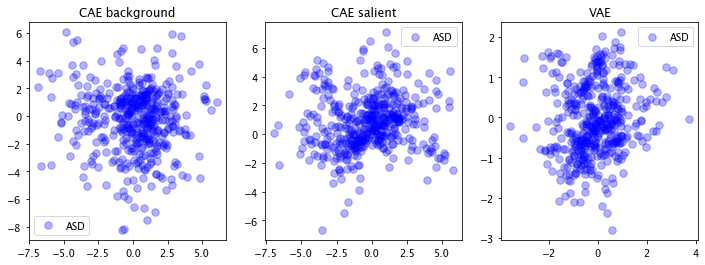

In [14]:
## Sanity Check - ASD subjects

v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']
project_data(data,dxArr,lbls)

In [15]:
encs = [z_encoder, s_encoder ,encoder]

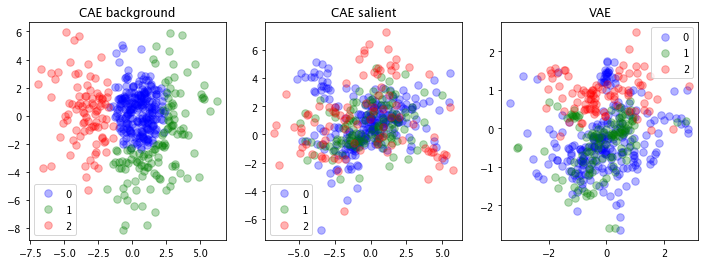

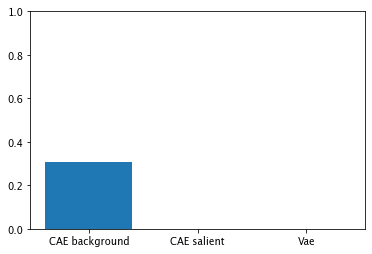

In [16]:
# Clustering defined on BACKGROUND features
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[0](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

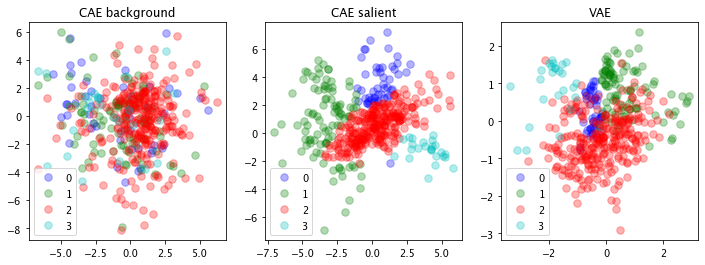

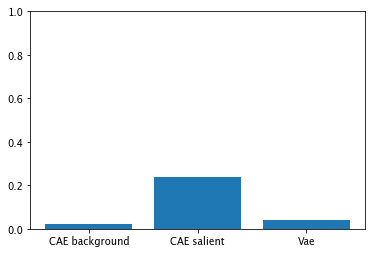

In [17]:
# Clustering defined on SALIENT features

v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[1](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

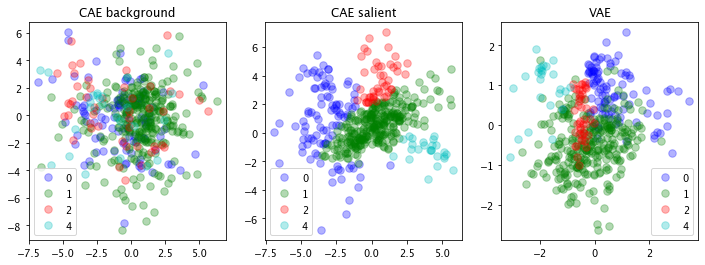

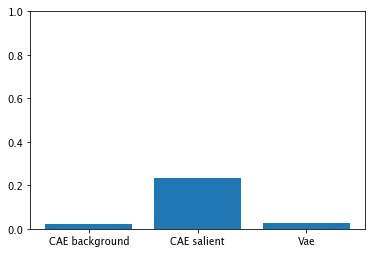

In [18]:
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[1](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

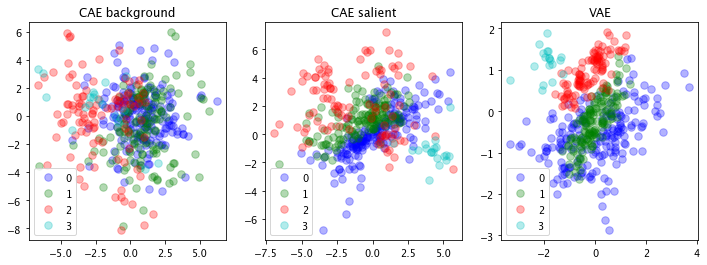

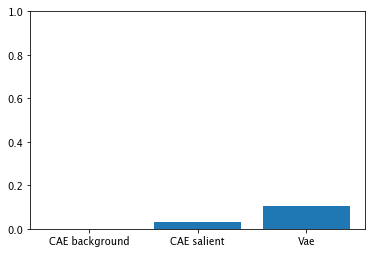

In [19]:
# Clustering defined on vanilla VAE
v = df['Subject Type'].values=='PATIENT'
data = ABIDE_data[v,:,:,:]; dxArr = np.ones(data.shape[0]); lbls = ['ASD']

bnpc = BayesianGaussianMixture(covariance_prior=None,covariance_type='full',degrees_of_freedom_prior=None,init_params='kmeans',max_iter=10000, mean_precision_prior=None,mean_prior=None,n_components=10,n_init=100,random_state=None,reg_covar=1e-06,tol=0.001,verbose=0,verbose_interval=10,warm_start=False,weight_concentration_prior=None,weight_concentration_prior_type='dirichlet_process')
cid_s = bnpc.fit_predict(np.array(encs[2](data)[2]))

lbls = [str(u) for u in np.unique(cid_s)];
dxArr = cid_s
project_data(data,dxArr=cid_s,lbls=lbls)

### ALTERNATIVE EXPLANATIONS OF CLUSTERING (age, IQ, etc.)

In [20]:
space_bg_abide = np.array(encs[0].predict(ABIDE_data)[2])
space_sl_abide = np.array(encs[1].predict(ABIDE_data)[2])
space_vae_abide = np.array(encs[2].predict(ABIDE_data)[2])

In [22]:
patients = df['Subject Type'].values=='PATIENT'
controls = df['Subject Type'].values=='CONTROL'
all_subs = patients+controls

In [23]:
def plot_cscatter(dxArr,v=np.arange(len(df)),clbl=None,clim=None):
    space_lbls = ['background','salient','VAE']
    spaces = [space_bg_abide, space_sl_abide, space_vae_abide]
    sub_slices = [controls,patients,patients]
    
    plt.figure(figsize=(15,5))
    for i in range(3):
        plt.subplot(1,3,i+1)
        space = spaces[i]
        v = sub_slices[i]
        plt.scatter(space[v,0],space[v,1],c=dxArr[v])
        if clim:
            plt.clim(clim[0],clim[1])
        cbar = plt.colorbar()
        #cbar.ax.set_ylabel(clbl, rotation=270)
        cbar.ax.set_ylabel(clbl, rotation=270,labelpad=20,fontsize=16,fontweight='bold')
        plt.title(space_lbls[i],fontsize=16,fontweight='bold')

    plt.subplots_adjust(
        left=None,
        bottom=None,
        right=None,
        top=None,
        wspace=.3,
        hspace=None,)

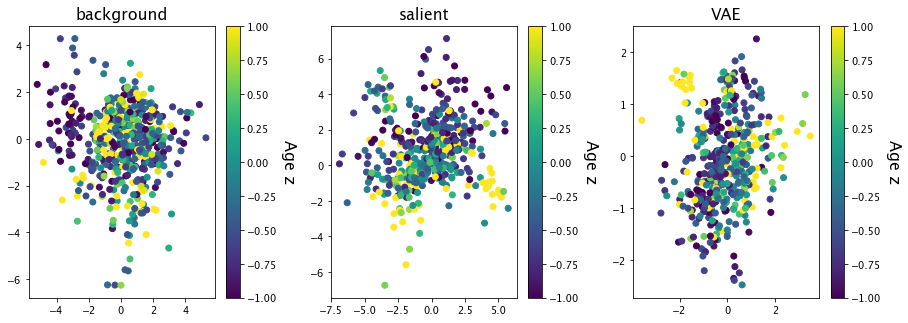

In [25]:
# AGE
ages = df['AgeAtScan'].values
agesz = (ages-ages.mean())/ages.std()
plot_cscatter(agesz,clbl='Age z',clim=(-1,1))

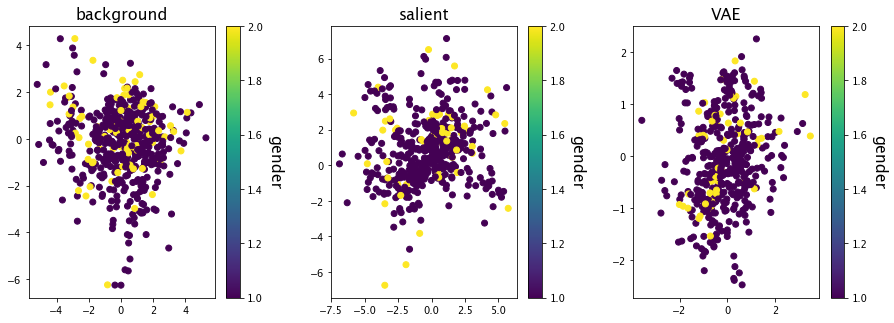

In [26]:
# Gender [1 - male; 2 - female]
gender = df['Sex'].values
plot_cscatter(gender,clbl='gender',clim=(1,2))

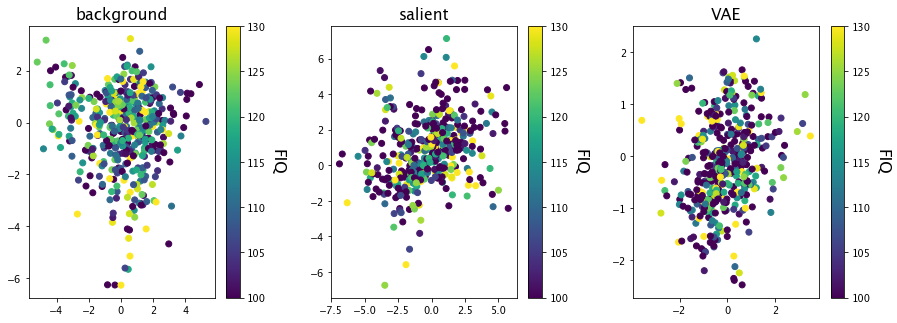

In [27]:
# FIQ - Fluid IQ scores 
fiq = df['FIQ'].values
fiq[abs(df['FIQ'].values)>200]=np.nan
plot_cscatter(fiq,clbl='FIQ',clim=(100,130),v=patients)

###  DSM diagnostic category (not sure what that exactly means)

[2 0 2 0 2 0 0 2 2 0]


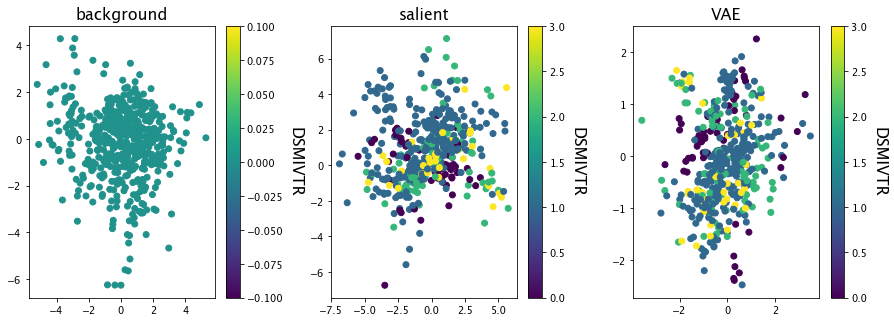

In [45]:
def numerize(val):
    try:
        return int(val)
    except:
        return 0
    
DSMIVTR = [numerize(val) for val in df['DSMIVTR'].values]
DSMIVTR = np.array(DSMIVTR)
print(DSMIVTR[0:10])
plot_cscatter(DSMIVTR,clbl='DSMIVTR',clim=None,v=patients)

## Brain Volume (z scored)

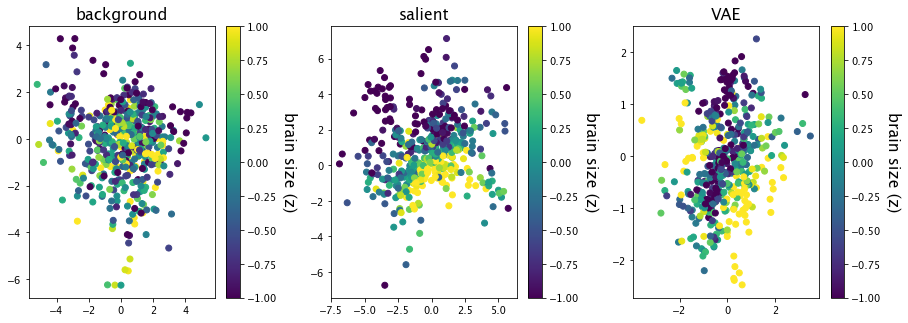

In [29]:
head_size = np.array(np.reshape(ABIDE_data,(ABIDE_data.shape[0],-1))>.02).sum(axis=1)
head_sizez = (head_size-head_size.mean())/head_size.std()
print(head_sizez[0:10])
plot_cscatter(head_sizez,clbl='brain size (z)',clim=(-1,1),v=controls)

In [30]:
df2 = pd.read_csv('/Users/aidasaglinskas/Desktop/BC-MRI-AE/CSVs/ABIDE_BIDS_PATHS.csv',index_col=0)
df2.index=np.arange(len(df2))
df2 = df2.iloc[np.array([df2['subID'].values[s] in df['BIDS_ID'].values for s in np.arange(len(df2))])]
df2.index=np.arange(len(df2))
df2 = df2.sort_values('subID')
df2.index=np.arange(len(df2))
print(f'{len(df2)}/{len(df)}')
n = len(df2)
df2.head()

assert len(df2)==len(df), 'different lenghts of CSVs'
assert all(np.array([df2['subID'].values[s]==df['BIDS_ID'].values[s] for s in np.arange(len(df))])),'mismatch between CSV orders'

982/982


In [49]:
center = [line.split('/')[6] for line in df2['sub_path'].values]
scanner = [line.split('/')[8] for line in df2['sub_path'].values]

In [52]:
def numerize(vec):
    vec = center
    vec = np.array(vec)
    numVec = np.zeros(vec.shape[0])
    u = np.unique(vec)
    n_u = len(u)


    for i in range(n_u):
        numVec[vec==u[i]]=i

    return numVec

### Scanner type has no effect in clustering (tiny effects and only for VAE)

['verio', 'verio', 'verio', 'verio', 'verio', 'verio', 'verio', 'verio', 'verio', 'verio']


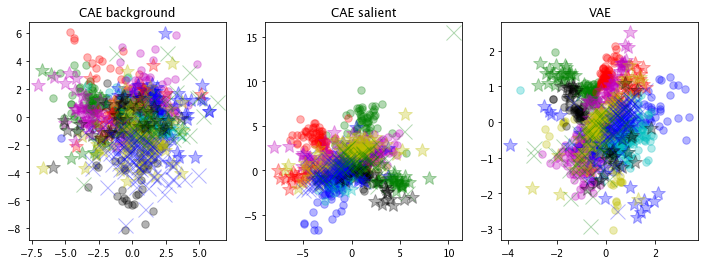

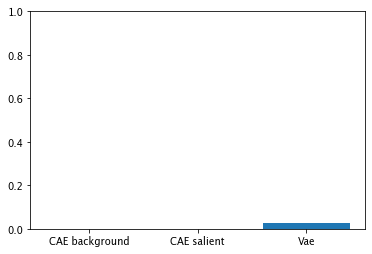

In [56]:
print(scanner[0:10])
project_data(ABIDE_data,dxArr=numerize(scanner),lbls=np.unique(scanner),legend=False)

In [58]:
print(center[0::50])

['mpg', 'mpg', 'ucla', 'sdsu', 'um', 'usm', 'usm', 'stanford', 'kul', 'nyu', 'nyu', 'nyu', 'nyu', 'caltech', 'kki', 'pitt', 'yale', 'sbl', 'sjh', 'ucla']


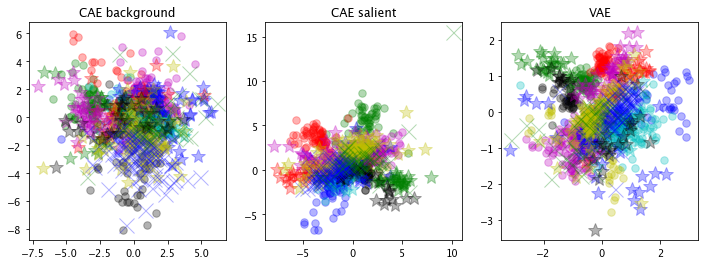

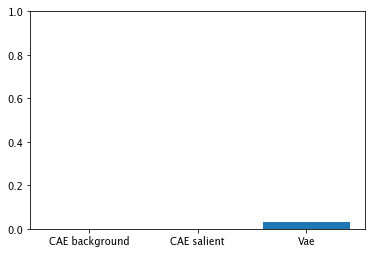

In [55]:
# SCANNING CENTER
project_data(ABIDE_data,dxArr=numerize(center),lbls=np.unique(scanner),legend=False)